# Deep Learning with PyTorch : Build an AutoEncoder

An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

![](denoising_autoencoder.png)

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

In this Project, you will see the simplest implemention of autoencoder for image denoising task.

In [3]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os

# Exploring Dataset 

In [8]:
data_path = os.path.join(os.path.dirname(os.path.abspath('')), os.pardir, "data", "mnist_dataset.csv")
print(os.path.exists(data_path))
data = pd.read_csv(data_path)
data.head()

True


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
image = data.iloc[18] #selecting image at index 3
image = np.array(image).astype('float32')
#(784, ) -> (28x28)

image = np.reshape(image, (28,28)) #reshaping
image = image/255 #scaling between 0 to 1 because there can be 0-255 intensities
print(image.shape)

(28, 28)


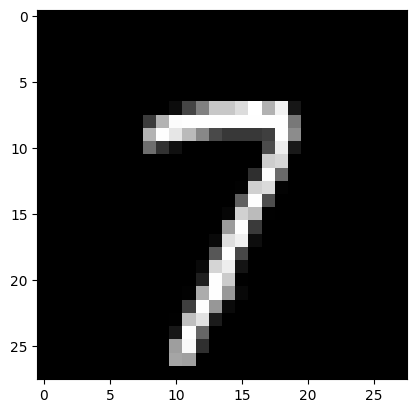

In [10]:
plt.imshow(image, cmap = 'gray')

In [11]:
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

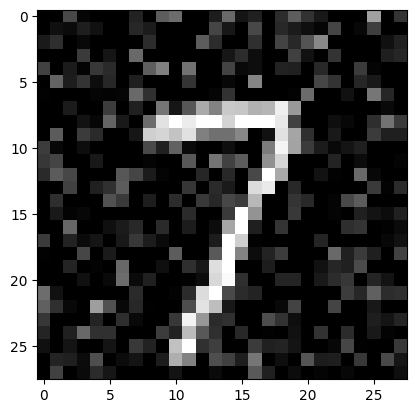

In [12]:
plt.imshow(noisy_image, cmap = "gray")

# Data Preparation 

In [13]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE

<img src="dataset.png" alt="drawing" width="400"/>

In [14]:
class MNIST_AE_Dataset(Dataset):
    
    def __init__(self, csv_file, transform =  None, noise_factor = 0.2):
        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img, (28,28,1))/255 # We are using grey scale images, mention channel s1
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        
        sample = (noisy_img, img)
        if self.transform:
            sample = self.transform(sample)
        
        return sample


### **Here to ToTensorForAE() is a custom transform which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.**

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [16]:
trainset = MNIST_AE_Dataset(data_path, transform=ToTensorForAE())

In [17]:
print(f"Size of trainset: {len(trainset)}")

Size of trainset: 42000


In [18]:
noisy_image, org_img = trainset[18]

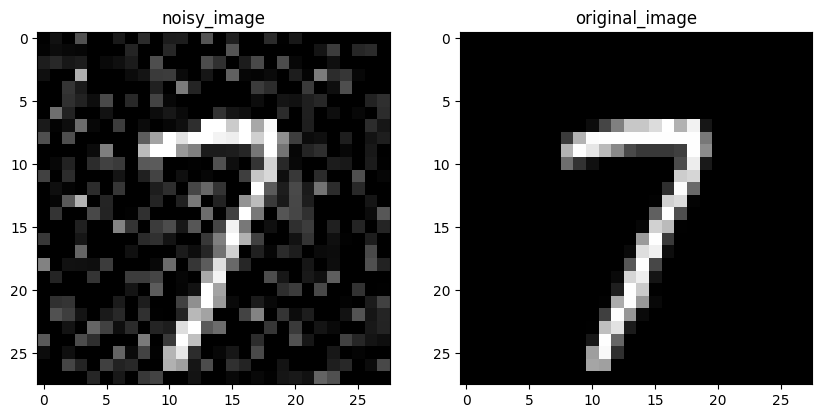

In [19]:
show_image(noisy_image=noisy_image, org_image=org_img)

# Load dataset into batches

In [20]:
from torch.utils.data import DataLoader

In [21]:
trainloader = DataLoader(dataset=trainset, batch_size=16, shuffle=True) #Training loop to shuffle every batch in each epoch

In [22]:
dataiter = iter(trainloader)
noisy_img, org_img = dataiter._next_data()
print(f"Shape of loading one batch: {noisy_img.shape}")
print(f"Total no. of batches {len(trainloader)}")
print(f"Total number of examples: {len(trainloader.dataset)}")

Shape of loading one batch: torch.Size([16, 1, 28, 28])
Total no. of batches 2625
Total number of examples: 42000


# Create AutoEncoder Model

In [23]:
from torch import nn
from torchinfo import summary

In [24]:
def Encoder():

    enc = nn.Sequential(

        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1) ,#in channels are gray scale
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1) ,#in channels are gray scale
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
    )

    return enc

In [25]:
def Decoder():

    dec = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(2,2), stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16, out_channels = 1, kernel_size=(2,2), stride=2),
        nn.Sigmoid()
    )

    return dec

In [26]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder =  Decoder()
    
    def forward(self, inp_imgs):
        encoder_out = self.encoder(inp_imgs)
        decoder_out = self.decoder(encoder_out)

        return decoder_out

model = AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [27]:
summary(model, input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 28, 28]               --
├─Sequential: 1-1                        [32, 7, 7]                --
│    └─Conv2d: 2-1                       [16, 28, 28]              160
│    └─ReLU: 2-2                         [16, 28, 28]              --
│    └─MaxPool2d: 2-3                    [16, 14, 14]              --
│    └─Conv2d: 2-4                       [32, 14, 14]              4,640
│    └─ReLU: 2-5                         [32, 14, 14]              --
│    └─MaxPool2d: 2-6                    [32, 7, 7]                --
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-7              [16, 14, 14]              2,064
│    └─ReLU: 2-8                         [16, 14, 14]              --
│    └─ConvTranspose2d: 2-9              [1, 28, 28]               65
│    └─Sigmoid: 2-10                     [1, 28, 28]               --
Total pa

# Train AutoEncoder Model 

In [1]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
epochs = 10

NameError: name 'torch' is not defined

In [29]:
for i in range(epochs):

    train_loss = 0.0

    for batch in tqdm(trainloader):
        noisy_img, org_img = batch
        denoised_img = model(noisy_img)
        loss = criterion(denoised_img, org_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    avg_train_loss = train_loss/len(trainloader)
    print(f"Epoch: {i+1} Train Loss: {avg_train_loss}")

100%|██████████| 2625/2625 [00:45<00:00, 57.77it/s]


Epoch: 1 Train Loss: 0.01638696193127405


100%|██████████| 2625/2625 [00:42<00:00, 62.43it/s]


Epoch: 2 Train Loss: 0.005621266803482458


100%|██████████| 2625/2625 [00:42<00:00, 62.25it/s]


Epoch: 3 Train Loss: 0.005150783620242561


100%|██████████| 2625/2625 [00:41<00:00, 63.66it/s]


Epoch: 4 Train Loss: 0.004939808590248937


100%|██████████| 2625/2625 [00:41<00:00, 63.65it/s]


Epoch: 5 Train Loss: 0.004816196773910806


100%|██████████| 2625/2625 [00:41<00:00, 62.99it/s]


Epoch: 6 Train Loss: 0.004728398996360955


100%|██████████| 2625/2625 [00:41<00:00, 63.38it/s]


Epoch: 7 Train Loss: 0.004664206195622683


100%|██████████| 2625/2625 [00:41<00:00, 62.74it/s]


Epoch: 8 Train Loss: 0.004607955262508421


100%|██████████| 2625/2625 [00:39<00:00, 65.98it/s]


Epoch: 9 Train Loss: 0.004572691543116456


100%|██████████| 2625/2625 [00:38<00:00, 67.97it/s]

Epoch: 10 Train Loss: 0.004530645467695736


In [30]:
print(len(trainset))
len(trainloader.dataset)

42000


42000

# Plot Results

torch.Size([1, 28, 28])


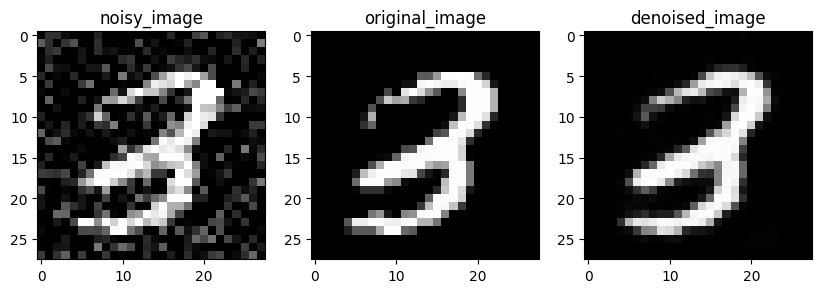

In [31]:
model.eval()

with torch.no_grad():

    dataiter = iter(trainloader)
    sample = dataiter._next_data()

    noisy_img, org_img = sample #

    index = 15

    denoised_img = model(noisy_img[index].unsqueeze(0)) # (channel, height, width) -> (bs, c, h, w)
    print(denoised_img.squeeze(0).shape)

    show_image(noisy_image=noisy_img[index], org_image=org_img[index], pred_image=denoised_img.squeeze(0))